# UMAP

- [1] A critical examination of robustness and generalizability of machine learning prediction of materials properties
- [2] Improved Time-Series Clustering with UMAP dimension reduction method



[1] @article{li2023critical,
  title={A critical examination of robustness and generalizability of machine learning prediction of materials properties},
  author={Li, Kangming and DeCost, Brian and Choudhary, Kamal and Greenwood, Michael and Hattrick-Simpers, Jason},
  journal={npj Computational Materials},
  volume={9},
  number={1},
  pages={55},
  year={2023},
  publisher={Nature Publishing Group UK London}
}

[2] https://ieeexplore.ieee.org/abstract/document/9412261

In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
import seaborn as sns

###########################################################
# Load Classifier and Data
###########################################################
pipeline = joblib.load('pipeline_classifier.pkl')
training_data = pd.read_csv("dataset/data_train.csv")
validation_data = pd.read_csv("dataset/data_validation.csv")

# Map labels to numerical values for binary classification
y_train = training_data['SOURCE'].map({'out': 0, 'in': 1})
X_train = training_data.drop(columns=['SOURCE'])
validation_data['SOURCE'] = validation_data['SOURCE'].map({'out': 0, 'in': 1})

###########################################################
# Preprocessing /  Predict
###########################################################
# Preprocess training data
X_train_preprocessed = pipeline.named_steps['preprocessor'].transform(X_train)

validation_data_features = validation_data.drop(columns=['SOURCE'])
validation_data_preprocessed = pipeline.named_steps['preprocessor'].transform(validation_data_features)


validation_predictions = pipeline.named_steps['classifier'].predict(validation_data_preprocessed)
true_labels = validation_data['SOURCE'].values
is_correct = validation_predictions == true_labels

results_df = pd.DataFrame({
    'true_label': true_labels,
    'predicted_label': validation_predictions,
    'is_correct': is_correct
})

/home/correia/Documents/Projects/pointwise-benchmark/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
###########################################################
# UMAP
###########################################################

# Combine training and validation
combined_data = np.vstack((X_train_preprocessed, validation_data_preprocessed))

# Apply UMAP
umap_reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
reduced_umap_data = umap_reducer.fit_transform(combined_data)

# Split
reduced_training_umap = reduced_umap_data[:len(X_train_preprocessed)]
reduced_validation_umap = reduced_umap_data[len(X_train_preprocessed):]

# create df
results_df['UMAP1'] = reduced_validation_umap[:, 0]
results_df['UMAP2'] = reduced_validation_umap[:, 1]

# Create training DataFrame for visualization
training_df_umap = pd.DataFrame(reduced_training_umap, columns=['UMAP1', 'UMAP2'])
training_df_umap['true_label'] = y_train

/home/correia/Documents/Projects/pointwise-benchmark/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


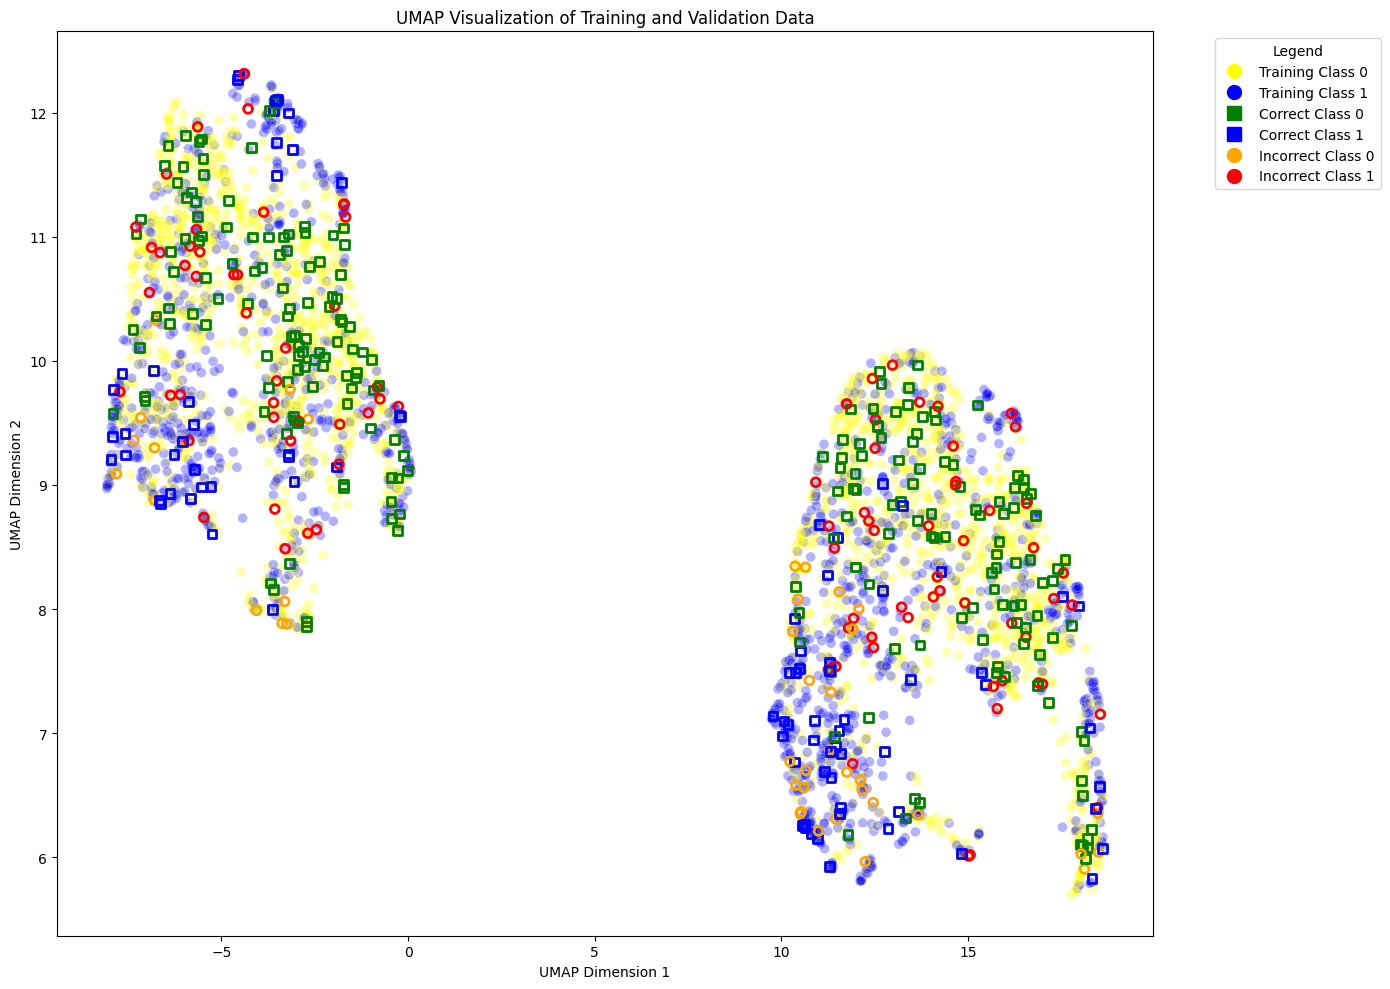

In [3]:
###########################################################
# Visualization
###########################################################
training_colors = {0: 'yellow', 1: 'blue'}
correct_colors = {0: 'green', 1: 'blue'}
incorrect_colors = {0: 'orange', 1: 'red'}

# Plot UMAP
plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=training_df_umap,
    x='UMAP1',
    y='UMAP2',
    hue='true_label',
    palette=training_colors,
    alpha=0.3,
    s=50,
    legend=False
)

# Validation
for _, row in results_df.iterrows():
    if row['is_correct']:
        plt.scatter(
            row['UMAP1'], row['UMAP2'],
            facecolors='none',  # No fill color
            edgecolors=correct_colors[row['true_label']],  # Class-specific border color
            marker='s',
            s=40,
            linewidth=2
        )
    else:
        # incorrect predictions (circles)
        plt.scatter(
            row['UMAP1'], row['UMAP2'],
            facecolors='none',
            edgecolors=incorrect_colors[row['true_label']],
            marker='o',
            s=40,
            linewidth=2
        )

plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='yellow', label='Training Class 0', markersize=10, linestyle=''),
        plt.Line2D([0], [0], marker='o', color='blue', label='Training Class 1', markersize=10, linestyle=''),
        plt.Line2D([0], [0], marker='s', color='green', label='Correct Class 0', markersize=10, linestyle=''),
        plt.Line2D([0], [0], marker='s', color='blue', label='Correct Class 1', markersize=10, linestyle=''),
        plt.Line2D([0], [0], marker='o', color='orange', label='Incorrect Class 0', markersize=10, linestyle=''),
        plt.Line2D([0], [0], marker='o', color='red', label='Incorrect Class 1', markersize=10, linestyle=''),
    ],
    bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend"
)
plt.title("UMAP Visualization of Training and Validation Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.tight_layout()
plt.show()
